In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
input_path = '/content/drive/MyDrive/mit/cv_project/data/raw'
train_features = np.load(os.path.join(input_path, 'train_features.npy'))
train_labels = np.load(os.path.join(input_path, 'train_labels.npy'))
val_features = np.load(os.path.join(input_path, 'val_features.npy'))
val_labels = np.load(os.path.join(input_path, 'val_labels.npy'))
test_features = np.load(os.path.join(input_path, 'test_features.npy'))
test_labels = np.load(os.path.join(input_path, 'test_labels.npy'))
print(train_features.shape[0], val_features.shape[0], test_features.shape[0])

14979 1877 1689


## Constants

In [ ]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph' ,
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

transformations = {
    'elevation': lambda x: np.clip(x, -40, 6500),
    'sin_th': lambda x: np.sin(np.deg2rad(x)),
    'cos_th': lambda x: np.cos(np.deg2rad(x)),
    'vs': lambda x: np.clip(x, 0.14, 29.13),
    'tmmn': lambda x: np.clip(x, 225.54, 314.88),
    'tmmx': lambda x: np.clip(x, 233.08, 327.14),
    'sph': lambda x: np.clip(x, 0, 0.02),
    'pr': lambda x: np.clip(x, 0, 20), #690.44
    'pdsi': lambda x: np.clip(x, -15, 15),
    'NDVI': lambda x: np.clip(x, 0, 10000),
    'population': lambda x: np.clip(x, 0, 810694),
    'erc': lambda x: np.clip(x, 0, 200),
    'PrevFireMask': lambda x:x
}



# Physics preprocessing

We clipped them using estimated min and max value given by the authors of the datasets:

**GRIDMET**

* tmmn - minimum temperature - should be between 225.54 and 314.88
* tmmx - max temperature - between 233.08 and 327.14
* sph - specific humidity - between 0 and 0.02
* vs - wind velocity at 10m - between 0.14 and 29.13
* pr - precipitation - 0 to 690.44
* th - wind direction - no min max, but should be between 0 and 360 (also 360 = 0, should we take the sinus????)
* erc - energy release component - between 0 and 131.85

**GRIDMET - drought**
pdsi (palmer drought severity index): -15 and 15
SRTM
elevation between -10 and 6500 => OK

**NDVI**
??? no min max

**GPWv4**
(pop density) - 0 to 810694
=> 0 is a special, it must be an obscured pixel from which we don't have data

## Functions (apply transform, plot)

In [ ]:
def apply_transformations(features, transformations):
    # apply the transformations to the features array
    # !! assumptions on ordering => knows that wind is index 2
    # (therefore it reads it twice and shift indices after)
    transformed_features = np.empty((features.shape[0], features.shape[1], features.shape[2], features.shape[3]+1))
    for i, name in enumerate(transformations.keys()):
        if i >= 2:
          transformed_features[..., i] = transformations[name](features[..., i-1])
        else:
          transformed_features[..., i] = transformations[name](features[..., i])
    return transformed_features


In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

variables = [  'Elevation',
  'Wind direction sin',
  'Wind direction cos',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precipitation',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask']
  #'Fire mask']

def plot_distributions(features, display_lines=True):
  # features should have 13 channels. Prev Fire Mask is not plot
  num_channels = features.shape[-1]
  num_features = len(variables)
  input_feature_stats = []
  for feature in range(num_features):
      feature_data = features[..., feature].flatten()
      mean = np.mean(feature_data)
      min = np.min(feature_data)
      max = np.max(feature_data)
      std = np.std(feature_data)
      input_feature_stats.append((mean, min, max, std))

  fig, axs = plt.subplots(3, 4, figsize=(12, 9))
  axs = axs.flatten()
  for feature in range(num_features):
      if feature == 12:
        continue
      if feature > 12:
        ax = axs[feature-1]
      else:
        ax = axs[feature]

      features_data = features[..., feature].flatten()
      ax.hist(features_data, bins=50, density=True, alpha=0.7)
      ax.set_title(variables[feature])
      ax.set_xlabel("Pixel Value")
      ax.set_ylabel("Density")

      mean, min_val, max_val, std = input_feature_stats[feature]
      if display_lines:
        ax.axvline(mean, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(mean + std, color='green', linestyle='--', linewidth=1.5)
        ax.axvline(mean - std, color='green', linestyle='--', linewidth=1.5)

      legend_text = (f"Min: {min_val:.2f}\nMax: {max_val:.2f}\n"
                    f"Mean: {mean:.2f}\nStd: {std:.2f}")
      ax.legend([plt.Line2D([], [], alpha=0)], [legend_text], handlelength=0)

  plt.tight_layout()
  plt.show()


In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

variables = [  'Elevation',
  'Wind direction sin',
  'Wind direction cos',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precipitation',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask']
  #'Fire mask']


def plot_distributions_split(train_features, val_features, test_features):
  # features should have 13 channels. Prev Fire Mask is not plot
  assert train_features.shape[-1] == val_features.shape[-1] == test_features.shape[-1], "All input datasets must have the same number of features"
  num_channels = train_features.shape[-1]
  num_features = len(variables)
  fig, axs = plt.subplots(3, 4, figsize=(12, 9))
  axs = axs.flatten()
  for feature in range(num_features):
      if feature == 12:
        continue
      if feature > 12:
        ax = axs[feature-1]
      else:
        ax = axs[feature]

      train_data = train_features[..., feature].flatten()
      val_data = val_features[..., feature].flatten()
      test_data = test_features[..., feature].flatten()
      ax.hist(train_data, bins=50, density=True, alpha=0.5, label=f'Train (mean: {np.mean(train_data):.2f}, std: {np.std(train_data):.2f})')
      ax.hist(val_data, bins=50, density=True, alpha=0.5, label=f'Val (mean: {np.mean(val_data):.2f}, std: {np.std(val_data):.2f})')
      ax.hist(test_data, bins=50, density=True, alpha=0.5, label=f'Test (mean: {np.mean(test_data):.2f}, std: {np.std(test_data):.2f})')
      ax.set_title(variables[feature])
      ax.set_xlabel("Pixel Value")
      ax.set_ylabel("Density")

  plt.tight_layout()
  plt.show()


## Before transformations

In [ ]:
no_transformations = {
    'elevation': lambda x: x,
     'sin_th': lambda x: x,
     'cos_th': lambda x: x,
     'vs': lambda x: x,
     'tmmn': lambda x: x,
    'tmmx': lambda x: x,
    'sph': lambda x: x,
    'pr': lambda x: x,
    'pdsi': lambda x: x,
    'NDVI': lambda x: x,
    'population': lambda x: x,
    'erc': lambda x: x,
    'prevFireMask': lambda x:x
}

no_t_train_features = apply_transformations(train_features, no_transformations)
no_t_val_features = apply_transformations(val_features, no_transformations)
no_t_test_features = apply_transformations(test_features, no_transformations)

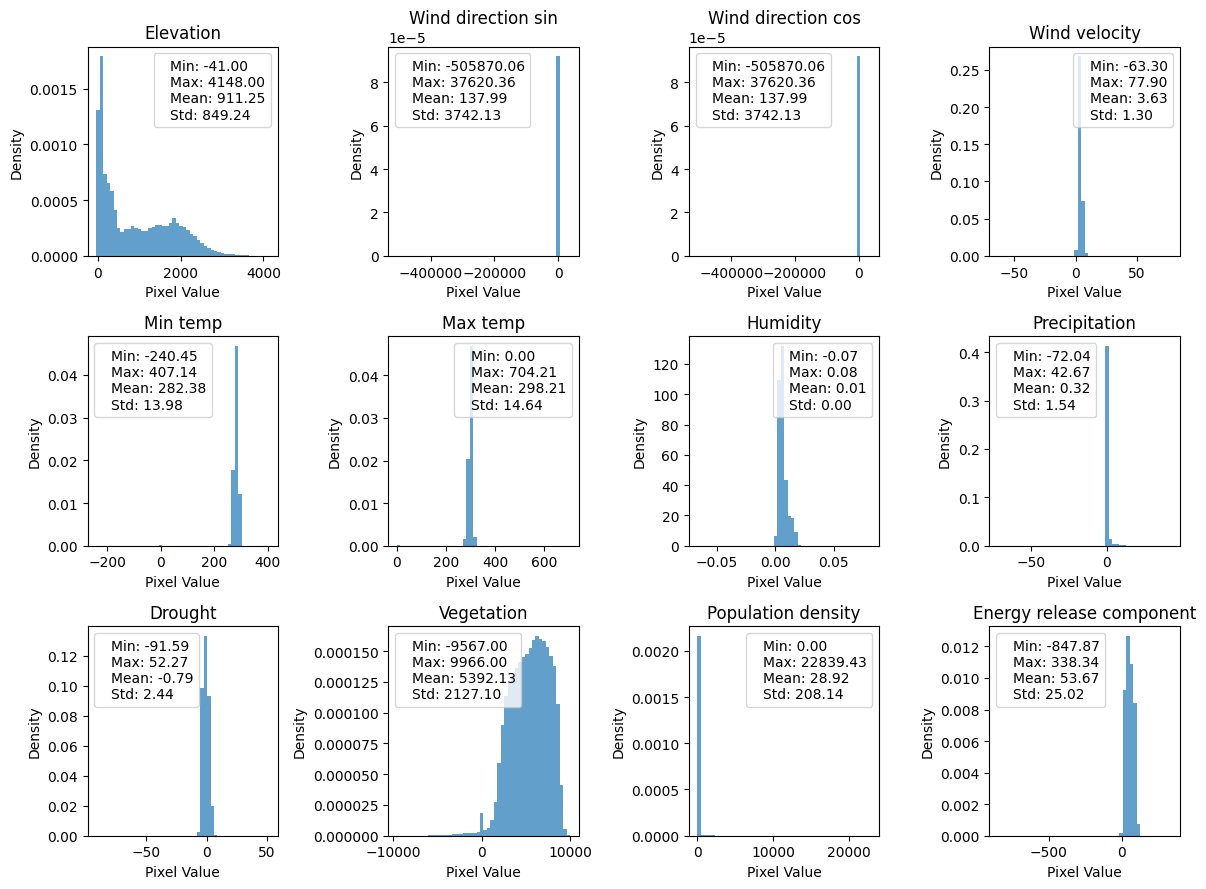

In [ ]:
plot_distributions(no_t_train_features, display_lines=False)

uggly ..

## After transformations

In [ ]:
transformations = {
    'elevation': lambda x: np.clip(x, -40, 6500),
    'sin_th': lambda x: np.sin(np.deg2rad(x)),
    'cos_th': lambda x: np.cos(np.deg2rad(x)),
    'vs': lambda x: np.clip(x, 0.14, 29.13),
    'tmmn': lambda x: np.clip(x, 225.54, 314.88),
    'tmmx': lambda x: np.clip(x, 233.08, 327.14),
    'sph': lambda x: np.clip(x, 0, 0.02),
    'pr': lambda x: np.clip(x, 0, 20), #690.44
    'pdsi': lambda x: np.clip(x, -15, 15),
    'NDVI': lambda x: np.clip(x, 0, 10000),
    'population': lambda x: np.clip(x, 0, 810694),
    'erc': lambda x: np.clip(x, 0, 200),
    'PrevFireMask': lambda x:x
}

t_train_features = apply_transformations(train_features, transformations)
t_val_features = apply_transformations(val_features, transformations)
t_test_features = apply_transformations(test_features, transformations)

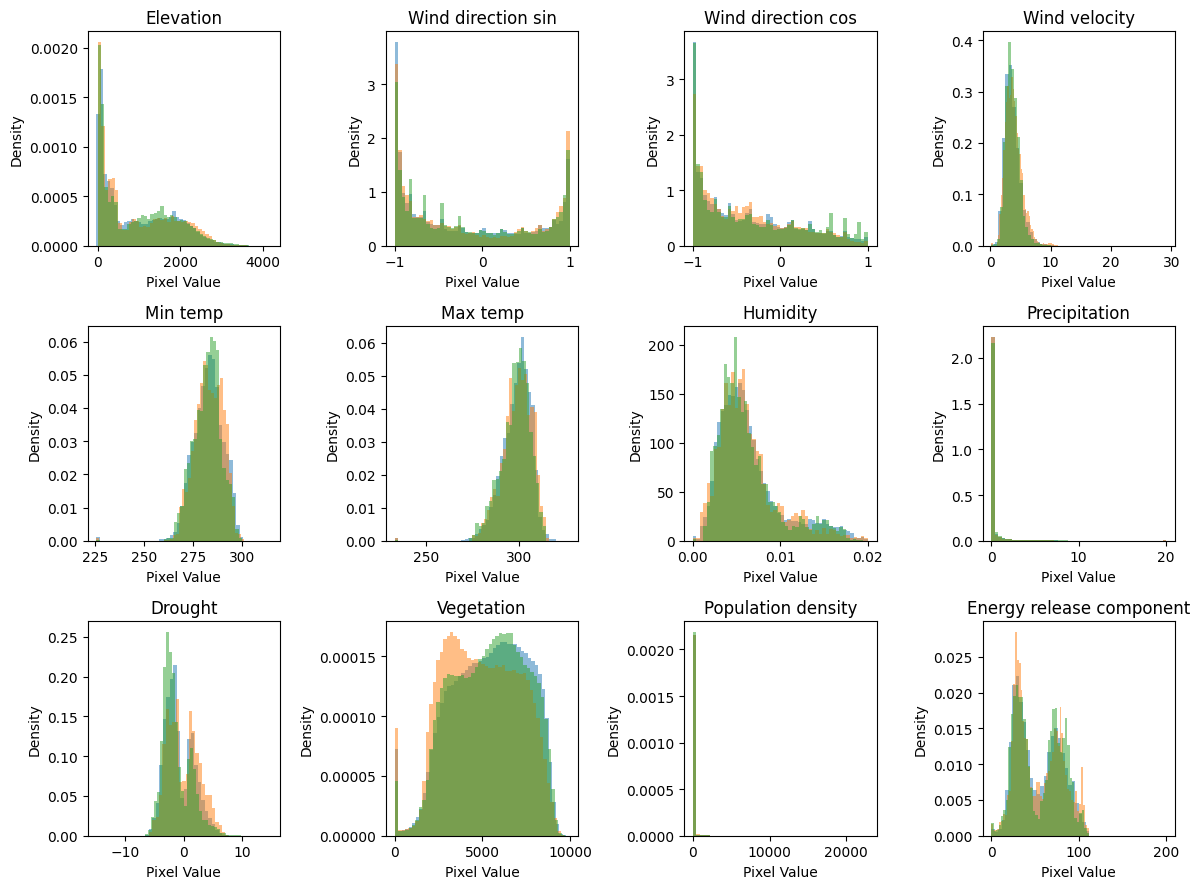

In [ ]:
plot_distributions_split(t_train_features, t_val_features, t_test_features)

# Data selection

## Target analysis

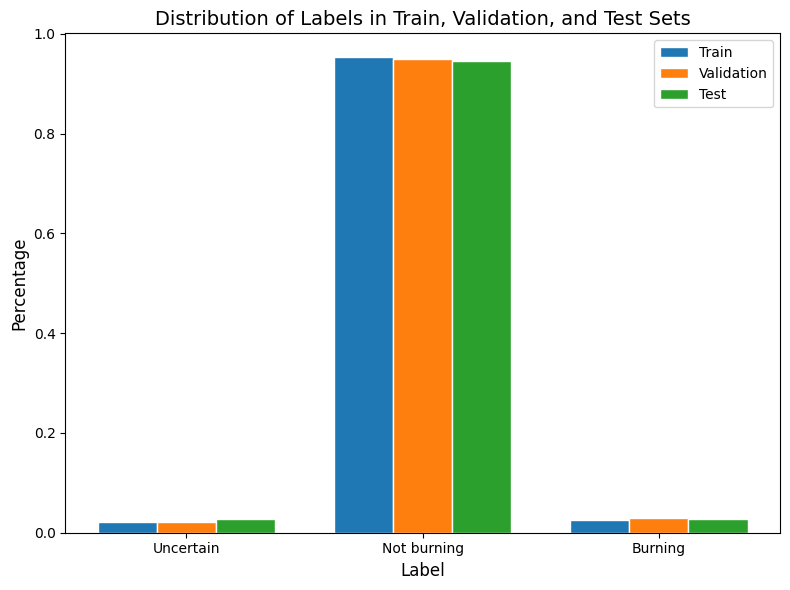

In [ ]:
import matplotlib.pyplot as plt

train_unique, train_counts = np.unique(train_labels, return_counts=True)
train_percentages = train_counts / train_counts.sum()

val_unique, val_counts = np.unique(val_labels, return_counts=True)
val_percentages = val_counts / val_counts.sum()

test_unique, test_counts = np.unique(test_labels, return_counts=True)
test_percentages = test_counts / test_counts.sum()

bar_width = 0.25

r1 = np.arange(len(train_unique))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(8, 6))
plt.bar(r1, train_percentages, width=bar_width, edgecolor='white', label='Train')
plt.bar(r2, val_percentages, width=bar_width, edgecolor='white', label='Validation')
plt.bar(r3, test_percentages, width=bar_width, edgecolor='white', label='Test')

plt.xlabel('Label', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Distribution of Labels in Train, Validation, and Test Sets', fontsize=14)
plt.xticks([r + bar_width for r in range(len(train_unique))], ['Uncertain', 'Not burning', 'Burning'])

plt.legend()

plt.tight_layout()
plt.show()

## Removing images with -1 (uncertain)

In [ ]:
# maskA = (train_features[..., -1] == -1).any(axis=(1, 2))
# maskB = (train_labels == -1).any(axis=(1, 2, 3))
# print(f"{maskA.sum()} images that contain a -1 \n{maskB.sum()} labels contain a -1")

In [ ]:
import numpy as np

def remove_uncertain_samples(features, labels):
  fire_mask = features[..., -1]

  maskA = (fire_mask != -1).all(axis=(1, 2)) # prev fire mask not uncertain
  maskB = (labels != -1).all(axis=(1, 2, 3)) # next fire mask not uncertain
  filter = maskA & maskB
  print(f"Removing {len(filter)-filter.sum()} fires with at least one uncertain pixel...")

  filtered_features = features[filter]
  filtered_labels = labels[filter]

  return filtered_features, filtered_labels

In [ ]:
def remove_unlit_samples(features, labels, threshold=10):
  # count unlit pixel per sample and select if sum is above threshold
  lit_pixels_per_fire = features[..., -1].sum(axis=(1, 2))
  mask = lit_pixels_per_fire >= threshold
  print(f"Removing {len(mask)-mask.sum()} fires with less than {threshold} unlit pixels...")
  return features[mask], labels[mask]

In [ ]:
pcts = np.percentile(train_features, q=[0.1, 99.9], axis=(0, 1, 2)).T

In [ ]:
pcts[1]

array([ -0.3644959 , 363.55410141])

In [ ]:
def symmetric_clip(x, min_val, max_val, pct_min_val, pct_max_val):
    new_min = max(min_val, pct_min_val)
    new_max = min(max_val, pct_max_val)
    return np.clip(x, new_min, new_max)

# Define the keys in the order they appear in `pcts`
key_order = ['elevation', 'sin_th', 'cos_th', 'vs', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
transformations = {
    'elevation': lambda x: symmetric_clip(x, -40, 6500, pcts[0][0], pcts[1][0]),
    'sin_th': lambda x: np.sin(np.deg2rad(x)),
    'cos_th': lambda x: np.cos(np.deg2rad(x)),
    'vs': lambda x: symmetric_clip(x, 0.14, 29.13, pcts[3][0], pcts[3][1]),
    'tmmn': lambda x: symmetric_clip(x, 225.54, 314.88, pcts[4][0], pcts[4][1]),
    'tmmx': lambda x: symmetric_clip(x, 233.08, 327.14, pcts[5][0], pcts[5][1]),
    'sph': lambda x: symmetric_clip(x, 0, 0.02, pcts[6][0], pcts[6][1]),
    'pr': lambda x: symmetric_clip(x, 0, 20, pcts[7][0], pcts[7][1]),
    'pdsi': lambda x: symmetric_clip(x, -15, 15, pcts[8][0], pcts[8][1]),
    'NDVI': lambda x: symmetric_clip(x, 0, 10000, pcts[9][0], pcts[9][1]),
    'population': lambda x: symmetric_clip(x, 0, 810694, pcts[10][0], pcts[10][1]),
    'erc': lambda x: symmetric_clip(x, 0, 200, pcts[11][0], pcts[11][1]),
    'PrevFireMask': lambda x: x  # No clipping needed for PrevFireMask
}

In [ ]:
transformations_phy = {
    'elevation': lambda x: np.clip(x, -40, 6500),
    'sin_th': lambda x: np.sin(np.deg2rad(x)),
    'cos_th': lambda x: np.cos(np.deg2rad(x)),
    'vs': lambda x: np.clip(x, 0.14, 29.13),
    'tmmn': lambda x: np.clip(x, 225.54, 314.88),
    'tmmx': lambda x: np.clip(x, 233.08, 327.14),
    'sph': lambda x: np.clip(x, 0, 0.02),
    'pr': lambda x: np.clip(x, 0, 20), #690.44
    'pdsi': lambda x: np.clip(x, -15, 15),
    'NDVI': lambda x: np.clip(x, 0, 10000),
    'population': lambda x: np.clip(x, 0, 810694),
    'erc': lambda x: np.clip(x, 0, 200),
    'PrevFireMask': lambda x:x
}




# Scaffolding function

In [ ]:
transformations_phy = {
    'elevation': lambda x: np.clip(x, -40, 6500),
    'sin_th': lambda x: np.sin(np.deg2rad(x)),
    'cos_th': lambda x: np.cos(np.deg2rad(x)),
    'vs': lambda x: np.clip(x, 0.14, 29.13),
    'tmmn': lambda x: np.clip(x, 225.54, 314.88),
    'tmmx': lambda x: np.clip(x, 233.08, 327.14),
    'sph': lambda x: np.clip(x, 0, 0.02),
    'pr': lambda x: np.clip(x, 0, 20), #690.44
    'pdsi': lambda x: np.clip(x, -15, 15),
    'NDVI': lambda x: np.clip(x, 0, 10000),
    'population': lambda x: np.clip(x, 0, 810694),
    'erc': lambda x: np.clip(x, 0, 200),
    'PrevFireMask': lambda x:x
}
import os
input_path = '/content/drive/MyDrive/mit/cv_project/data/raw'
train_features = np.load(os.path.join(input_path, 'train_features.npy'))
train_labels = np.load(os.path.join(input_path, 'train_labels.npy'))
val_features = np.load(os.path.join(input_path, 'val_features.npy'))
val_labels = np.load(os.path.join(input_path, 'val_labels.npy'))
test_features = np.load(os.path.join(input_path, 'test_features.npy'))
test_labels = np.load(os.path.join(input_path, 'test_labels.npy'))
print(train_features.shape[0], val_features.shape[0], test_features.shape[0])

def preprocess(features, labels, transformations, threshold):
  features = apply_transformations(features, transformations)
  features, labels = remove_uncertain_samples(features, labels)
  features, labels = remove_unlit_samples(features, labels)
  return features, labels

threshold = 10 # median
train_features, train_labels = preprocess(train_features, train_labels, transformations_phy, threshold)
val_features, val_labels = preprocess(val_features, val_labels, transformations_phy, threshold)
test_features, test_labels = preprocess(test_features, test_labels, transformations_phy, threshold)

In [ ]:
train_features.shape

In [ ]:
def change_features(features):
  c = features.shape[-1]
  output = np.empty((*features.shape[:-1], c - 1))
  print(output.shape)
  for i in range(c-1):
    if i==0:
      output[..., i] = features[...,i] #elevation
    elif i==1:
      output[...,i] = features[..., i] * features[..., 3]
    elif i==2:
      output[...,i] = features[..., i] * features[..., 3]
    else:
      output[...,i] = features[..., i+1]
  return output
train_features = change_features(train_features)
val_features = change_features(val_features)
test_features = change_features(test_features)

In [ ]:
pcts = np.percentile(train_features, q=[0.1, 99.9], axis=(0, 1, 2)).T

transformations_qtile = [lambda x, p=pcts[i]: np.clip(x, *p) for i in range(len(pcts))]
transformations_qtile[-1] = lambda x:x

In [ ]:
def apply_transfo_stats(features, transformations):
  transformed_features = np.zeros_like(features)
  for i, transfo in enumerate(transformations_qtile):
    transformed_features[..., i] = transfo(features[..., i])
  return transformed_features
train_features = apply_transfo_stats(train_features, transformations_qtile)
val_features = apply_transfo_stats(val_features, transformations_qtile)
test_features = apply_transfo_stats(test_features, transformations_qtile)

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

TITLES = [
  'Elevation',
  'Horizontal wind',
  'Vertical wind',
  'Min temperature',
  'Max temperature',
  'Humidity',
  'Precipitation',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask'
]
  #'Fire mask']
UNITS = ["m", "m/s", "m/s", "K", "K", "kg/kg", "mm", "index", "index", "people per km²", "index", "burning pixel"]

def plot_distributions_split(train_features, val_features, test_features):
  # features should have 13 channels. Prev Fire Mask is not plot
  assert train_features.shape[-1] == val_features.shape[-1] == test_features.shape[-1], "All input datasets must have the same number of features"
  num_channels = train_features.shape[-1]
  num_features = len(TITLES)
  fig, axs = plt.subplots(3, 4, figsize=(12, 9))
  axs = axs.flatten()
  for feature in range(num_features):


      ax = axs[feature]

      train_data = train_features[..., feature].flatten()
      val_data = val_features[..., feature].flatten()
      test_data = test_features[..., feature].flatten()
      ax.hist(test_data, bins=50, color="#FDB745", density=True, alpha=0.7, label=f'Test (mean: {np.mean(test_data):.2f}, std: {np.std(test_data):.2f})')
      ax.hist(val_data, bins=50, color="#6E19AE", density=True, alpha=0.7, label=f'Val (mean: {np.mean(val_data):.2f}, std: {np.std(val_data):.2f})')
      ax.hist(train_data, bins=50, color="#332CD0", density=True, alpha=0.5, label=f'Train (mean: {np.mean(train_data):.2f}, std: {np.std(train_data):.2f})')
      ax.set_title(TITLES[feature], fontsize=14)
      ax.set_xlabel(UNITS[feature], fontsize=12)
      ax.set_ylabel("Density")

  plt.tight_layout()
  plt.show()


In [ ]:
def find_original_color(hex_color, alpha=0.7):
    # Convert hex to RGB
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:], 16)

    # Calculate the original color assuming the given color is with the specified alpha
    original_r = int(r / alpha)
    original_g = int(g / alpha)
    original_b = int(b / alpha)

    # Ensure that RGB values are within the valid range [0, 255]
    original_r = min(255, max(0, original_r))
    original_g = min(255, max(0, original_g))
    original_b = min(255, max(0, original_b))

    # Convert RGB back to hex
    original_hex = f"#{original_r:02X}{original_g:02X}{original_b:02X}"

    return original_hex

# Colors with alpha=0.7
colors_with_alpha = ['#241F92', '#6E19AE', '#FDB745']

# Calculate original colors
original_colors = [find_original_color(color) for color in colors_with_alpha]
original_colors


['#332CD0', '#9D23F8', '#FFFF62']

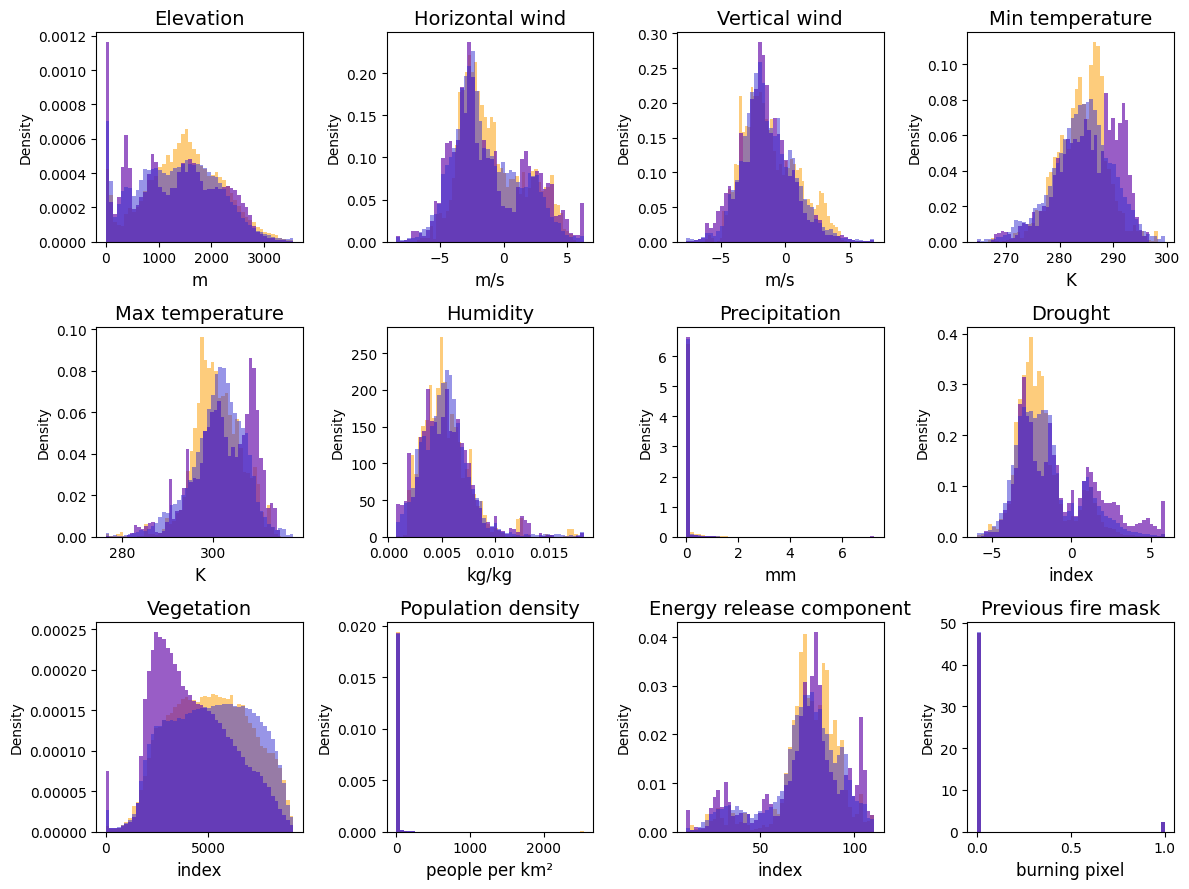

In [ ]:
plot_distributions_split(train_features, val_features, test_features)

In [ ]:
output_path = "/content/drive/MyDrive/mit/cv_project/data/preprocessed/clipped_phy_stats_wind"
print(train_features.shape[0], val_features.shape[0], test_features.shape[0])

4301 545 472


In [ ]:
train_features[..., -1].sum(axis=(1,2)).min()

10.0

In [ ]:
np.save(os.path.join(output_path, 'train_features.npy'), train_features)
np.save(os.path.join(output_path, 'train_labels.npy'), train_labels)
np.save(os.path.join(output_path, 'val_features.npy'), val_features)
np.save(os.path.join(output_path, 'val_labels.npy'), val_labels)
np.save(os.path.join(output_path, 'test_features.npy'), test_features)
np.save(os.path.join(output_path, 'test_labels.npy'), test_labels)

# Analysis

,0
count,4301.000000
mean,45.693560
std,44.113348
min,10.000000
25%,17.000000
50%,31.000000
75%,57.000000
max,416.000000


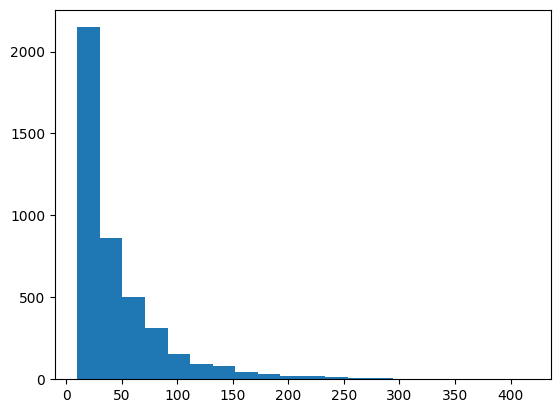

In [ ]:
lit_pixels_per_fire = train_features[..., -1].sum(axis=(1, 2))
plt.hist(lit_pixels_per_fire, bins=20)
import pandas as pd
pd.DataFrame(lit_pixels_per_fire).describe()